In [3]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import mediapipe as mp


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# detector = MTCNN(image_size=224,device=device, post_process=False)


In [4]:
mp_drawing = mp.solutions.drawing_utils
point_drawing_spec = mp_drawing.DrawingSpec(thickness=4, circle_radius=1)
line_drawing_spec = mp_drawing.DrawingSpec(thickness=4, color=[255,100,100])

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5)

fm = {'fm' : face_mesh, 'ds':mp_drawing }


# MediaPipe

In [16]:
def crop_left_eye(img, multi_face_landmarks) :

    for face_landmark in multi_face_landmarks:
        le_left_x = int(face_landmark.landmark[130].x * img.shape[1])
        le_left_y = int(face_landmark.landmark[27].y * img.shape[0])
        le_right_x = int(face_landmark.landmark[243].x * img.shape[1])
        le_right_y = int(face_landmark.landmark[23].y * img.shape[0])

        cropped_eye = img[le_left_y:le_right_y, le_left_x:le_right_x]
#         img[le_left_y:le_right_y, le_left_x:le_right_x] = cv2.blur(cropped_eye, (20, 20))
        
    return img, cropped_eye

In [17]:
def mediapipe_infer(img, fm) :
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = fm['fm'].process(img)

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
        return None
    
    annotated_image = img.copy()
    face_landmark_coord = {'x':[], 'y':[], 'z':[]}
    color=[255,100,100]


    annotated_image,cropped_eye = crop_left_eye(annotated_image, results.multi_face_landmarks)

    return annotated_image , cropped_eye
    


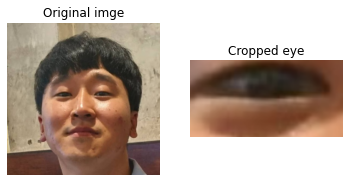

In [19]:
img = cv2.imread('./test_align.png',cv2.IMREAD_COLOR)
annotated_image, cropped_eye = mediapipe_infer(img, fm)
# annotated_image = mediapipe_infer(img, fm)
# print(face_landmark_coord)


fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original imge')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2RGB))
ax2.set_title('Cropped eye')
ax2.axis("off")
 
plt.show()

# plt.imshow(annotated_image)
# cv2.imwrite('./cropped_eye.jpg', cropped_eye)

# Read and Write Video 

In [48]:
def video_infer(video_path, output_path) :
    cap = cv2.VideoCapture(video_path)

    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_cnt = round(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)



    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    cnt = 1
    while True :

        ret, frame = cap.read()

        if ret :
            print(f"Complete [{cnt} / {frame_cnt}] {frame.shape}",end="\r")
            cnt += 1

            landmark = mediapipe_infer(frame, fm)

            if landmark is None : 
                out.write(frame)
                continue

            out.write(landmark)

        else:
            break

    cap.release()
    out.release()


In [54]:
video_path = "test.mp4"
output_path = "kernel_20_output.avi"

video_infer(video_path, output_path)

## Face Detector 성능

### MTCNN
    - 옆 모습 잘 못찾음
    - 정확도가 너무 떨어짐
    - 삭제함
    
### MediaPipe
    - 일단 성능은 보장됨.
    - mediapipe로 multi face landmark 가능한지 확인하기 -> 싱글 페이스 먼저 ㄱㄱ
    - detection 능력 너무 떨어짐.
    - 일정 거리 이상되면 얼굴 못찾음
    - 일단 단거리 & 싱글페이스 먼저 
    - face_landmark 좌표 가져온것 & opencv로 얼굴에 직접 찍어보기 -> 완료

### 윙크 만들기
    1. 눈 감은 상태를 덮어 씌운다. -> 제일 쉬운 방법
    2. 눈꺼풀 픽셀 값으로 눈동자를 채운다. -> 어려움 생각이 많이 필요할 듯 근데 만들면 의미 있을듯
    3. GAN 이용해서 눈을 새로 그려준다 -> 눈동자 픽셀 그리는 것보다 좋을 듯
    

# 코드 세이브